In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
import nltk
import re
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv("CVAssignmentDataset.csv")

In [5]:
df

,Class,Text
0,1,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,1,RT @WinterHavenSun: Winter Haven resident / Al...
2,1,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,1,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,1,RT @Vegalteno: Hurricane season starts on June...
...,...,...
86456,0,Check out my op-ed on need for End Executive O...
86457,0,"Yesterday, Betty &amp; I had a great time lear..."
86458,0,We are forever grateful for the service and sa...
86459,0,Happy first day of school @CobbSchools! #CobbB...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86461 entries, 0 to 86460
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   86461 non-null  object
 1   Text    86460 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [7]:
df=df.dropna()

In [8]:
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
df

,Class,Text
0,0,"Today is #TaxDay, which means the last day of ..."
1,0,Barry Wood and Gerald Dennis from the @America...
2,1,This young Knight represented @HCPSRobinsonHS ...
3,0,RT @HouseGOP: A little snow won’t stop us. #vo...
4,1,"Because otherwise, as Albert Einstein pointed ..."
...,...,...
86455,0,Congressman Leonard Lance today was ranked one...
86456,1,The #impeachment is based on incident BEFORE h...
86457,0,Remembering Dr. King's life &amp; legacy in ou...
86458,0,Great article! I enjoyed chatting with many fo...


<AxesSubplot:xlabel='Class', ylabel='count'>

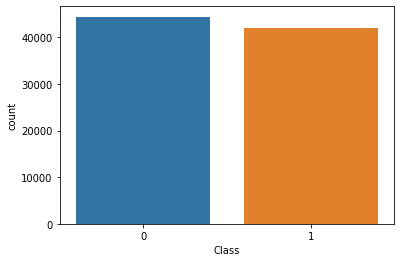

In [10]:
sns.countplot(x= 'Class',data = df)

In [13]:
df.Class.value_counts()

0    44392
1    42068
Name: Class, dtype: int64

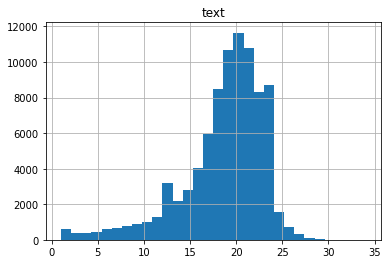

In [11]:
text_word_count = []
# populate the lists with sentence lengths
for i in df.Text:
      text_word_count.append(len(i.split()))
length_df = pd.DataFrame({'text':text_word_count})
length_df.hist(bins = 30)
plt.show()

In [14]:
cnt=0
for i in df.Text:
    if(len(i.split())<=50):
        cnt=cnt+1
print(cnt/len(df.Text))

1.0
